# Binary Classification Deep Learning Model for Cats and Dogs Using Keras Take 4
### David Lowe
### January 27, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The "Cats and Dogs" dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof). ASIRRA (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately.

The current literature suggests that machine classifiers can score above 80% accuracy on this task. Therefore, ASIRRA is no longer considered safe from attack. Kaggle created a contest to benchmark the latest computer vision and deep learning approaches to this problem. The training archive contains 25,000 images of dogs and cats. We will need to train our algorithm on these files and predict the correct labels for the test dataset.

In iteration Take1, we constructed a simple VGG convolutional model with 1 VGG block to classify the images. This model serves as the baseline for the future iterations of modeling.

In iteration Take2, we constructed a simple VGG convolutional model with 2 VGG blocks to classify the images. The additional modeling enabled us to improve our baseline model.

In iteration Take3, we constructed a simple VGG convolutional model with 3 VGG blocks to classify the images. The additional modeling enabled us to improve our baseline model further.

In this iteration, we will apply dropout to our 3-VGG model. We hope the addition of the dropout layers will improve our model.

ANALYSIS: In iteration Take1, the performance of the Take1 model achieved an accuracy score of 95.55% after training for 20 epochs. The same model, however, processed the test dataset with an accuracy of only 72.99% after 20 epochs. Reviewing the plot, we can see that the model was starting to overfit the training dataset after only ten epochs. We will need to explore other modeling approaches to reduce the over-fitting.

In iteration Take2, the performance of the Take2 model achieved an accuracy score of 97.94% after training for 20 epochs. The same model, however, processed the test dataset with an accuracy of only 75.67% after 20 epochs. Reviewing the plot, we can see that the model was starting to overfit the training dataset after only seven epochs. We will need to explore other modeling approaches to reduce the over-fitting.

In iteration Take3, the performance of the Take3 model achieved an accuracy score of 97.14% after training for 20 epochs. The same model, however, processed the test dataset with an accuracy of only 80.19% after 20 epochs. Reviewing the plot, we can see that the model was starting to overfit the training dataset after only six epochs. We will need to explore other modeling approaches to reduce the over-fitting.

In this iteration, the performance of the Take4 model achieved an accuracy score of 86.92% after training for 50 epochs. The same model, however, processed the test dataset with an accuracy of 81.04% after 50 epochs. By reviewing the plot, this iteration indicated to us that having dropout layers can be a good tactic to improve the model's predictive performance.

CONCLUSION: For this dataset, the model built using Keras and TensorFlow did not achieve a comparable result with the Kaggle competition. We should explore and consider more and different modeling approaches.

Dataset Used: Cats and Dogs Dataset

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://www.microsoft.com/en-us/download/details.aspx?id=54765

One potential source of performance benchmarks: https://www.kaggle.com/c/dogs-vs-cats/overview

Any deep-learning modeling project genrally can be broken down into about six major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
from matplotlib import pyplot
from matplotlib.image import imread
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
val_ratio = 0.25

# Set various default Keras modeling parameters
default_loss = 'binary_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.optimizers.SGD(learning_rate=0.001, momentum=0.9)
default_kernel_init = tf.initializers.he_uniform(seed=seedNum)
default_epoch = 50
default_batch = 64

Num GPUs Available:  1


In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [7]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [8]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

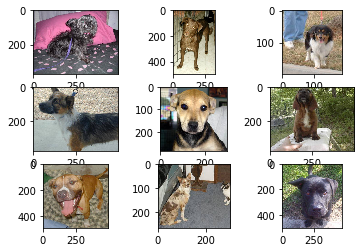

In [9]:
# Plot some dog photos from the dataset
folder = 'train/'
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	filename = folder + 'dog.' + str(i) + '.jpg'
	image = imread(filename)
	pyplot.imshow(image)
pyplot.show()

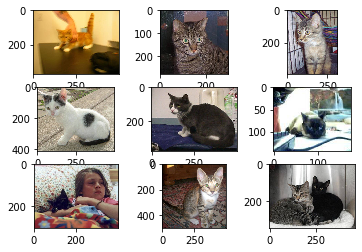

In [10]:
# Plot some cat photos from the dataset
folder = 'train/'
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	filename = folder + 'cat.' + str(i) + '.jpg'
	image = imread(filename)
	pyplot.imshow(image)
pyplot.show()

## 1.b) Data Cleaning

In [11]:
# Not required for this iteration of the project

## 1.c) Feature Scaling and Pre-processing

In [12]:
# Create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        os.makedirs(newdir, exist_ok=True)

# Seed the random number generator
reset_random(seedNum)

# Copy training dataset images into subdirectories
src_directory = 'train/'
for file in os.listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random.random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        shutil.copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        shutil.copyfile(src, dst)

In [13]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [14]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [15]:
# Define the Keras model for baseline measurement
def create_default_model():
    default_model = Sequential()
    default_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=default_kernel_init, padding='same', input_shape=(200, 200, 3)))
    default_model.add(MaxPooling2D((2, 2)))
    default_model.add(Dropout(0.2))
    default_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=default_kernel_init, padding='same'))
    default_model.add(MaxPooling2D((2, 2)))
    default_model.add(Dropout(0.3))
    default_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=default_kernel_init, padding='same'))
    default_model.add(MaxPooling2D((2, 2)))
    default_model.add(Dropout(0.4))
    default_model.add(Flatten())
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(1, activation='sigmoid', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [16]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [17]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [18]:
# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model = create_default_model()

# Create data generator and prepare the iterators
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/', class_mode='binary', 
                                       batch_size=default_batch, target_size=(200, 200))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/', class_mode='binary', 
                                      batch_size=default_batch, target_size=(200, 200))
baseline_hist = baseline_model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, 
                                   validation_steps=len(test_it), epochs=default_epoch, verbose=1)
_, acc = baseline_model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
print('The final validation accuracy measure for the model > %.3f' % (acc * 100.0))
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Found 18802 images belonging to 2 classes.
Found 6198 images belonging to 2 classes.
Train for 294 steps, validate for 97 steps
Epoch 1/50
294/294 [==============================] - 132s 448ms/step - loss: 0.7327 - accuracy: 0.5133 - val_loss: 0.6927 - val_accuracy: 0.4995
Epoch 2/50
294/294 [==============================] - 130s 443ms/step - loss: 0.6883 - accuracy: 0.5385 - val_loss: 0.6887 - val_accuracy: 0.5305
Epoch 3/50
294/294 [==============================] - 129s 440ms/step - loss: 0.6779 - accuracy: 0.5684 - val_loss: 0.6855 - val_accuracy: 0.5189
Epoch 4/50
294/294 [==============================] - 127s 433ms/step - loss: 0.6650 - accuracy: 0.5915 - val_loss: 0.6869 - val_accuracy: 0.5086
Epoch 5/50
294/294 [==============================] - 127s 433ms/step - loss: 0.6517 - accuracy: 0.6055 - val_loss: 0.6675 - val_accuracy: 0.5731
Epoch 6/50
294/294 [==============================] - 127s 434ms/step - loss: 0.6375 - accuracy: 0.6233 - val_loss: 0.6390 - val_accuracy: 0.6

In [19]:
# List all data points in the baseline model training history
print(baseline_hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


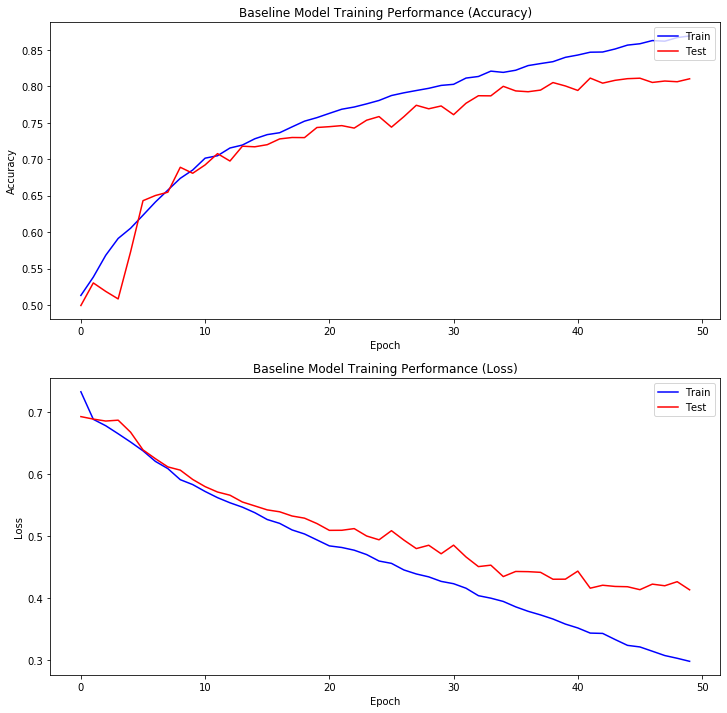

In [20]:
# Summarize model training hisotry for accuracy and loss
fig, axs = pyplot.subplots(2, 1, figsize=(12,12))
pyplot.subplot(211)
pyplot.plot(baseline_hist.history['accuracy'], color='blue', label='train')
pyplot.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
pyplot.title('Baseline Model Training Performance (Accuracy)')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Test'], loc='upper right')
pyplot.subplot(212)
pyplot.plot(baseline_hist.history['loss'], color='blue', label='train')
pyplot.plot(baseline_hist.history['val_loss'], color='red', label='test')
pyplot.title('Baseline Model Training Performance (Loss)')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['Train', 'Test'], loc='upper right')
pyplot.show()

In [21]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [22]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [23]:
# Not required for this iteration of the project

In [24]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [25]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [26]:
# Not required for this iteration of the project

In [27]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [28]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1:47:08.941764
